In [1]:
import biosignalsnotebooks as bsnb
from numpy import linspace, diff, zeros_like, arange, array
from scipy import signal
from scipy.signal import correlate
import scipy as sp
from scipy.signal import find_peaks
import math
from scipy import signal as scisig
import neurokit2 as nk
import statistics
import math

import biosignalsnotebooks as bsnb
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft

In [2]:
%run "3.0 - Functions_peakdetection.ipynb"

# 1) Time domain HRV parameters:
## 1.1) R-R intervals

In [16]:
#This function aims to calculate the R_R intervals, apply some correction, and plot the R-R intervals vs time (ms)
def RR_calculator(peaks):

    #Defining and initializing data structures
    x_values = peaks['x_values'].values #Taking the x values of the peaks and putting them in an array
    RR = []                            #Creating an array to the store the corresponding R_R intervals
    RR_data = pd.DataFrame(columns=['x_value','R-R Interval Raw', 'R-R Interval Final']) #Creating a dataframe to store the R_R intervals along their position
    
    #R-R interval calculation
    for index, value in enumerate(x_values): # The for loop ends if the index values get bigger than the array itself.
        if index+1 == len(peaks) :
            break
        diff = x_values[index+1]-x_values[index]
        RR.append(diff)

    RR_data['x_value']= x_values[0:len(x_values)-1] #Storing the x values and the raw R-R intervals in the data frame
    RR_data['R-R Interval Raw']= RR 

    #Processing the raw R-R interval data by removing the mean, applying a sliding window, and removing the outliers
    RR_mean = np.mean(RR) #Mean removal
    RR = RR-RR_mean
 
    RR_final = []
    n = 0
    while n < len(RR): #Sliding window
        i = 0
        window_values = []
        while i < 500: # The sliding window has a value of 500
            if n >= len(RR):
                break
            window_values.append(RR[n])
            n += 1
            i += 1
            
        if len(window_values) > 1:
            mean_w = np.mean(window_values) # The values that are found to be two standard deviations from the mean are changed by the mean value of the window.
            std_w = statistics.stdev(window_values)
            for index, value in enumerate(window_values):
                if value > (mean_w+2*std_w):
                    window_values[index] = mean_w + 2*std_w
                elif value < -(mean_w+2*std_w):
                    window_values[index] = -(mean_w + 2*std_w)
                    
            RR_final = RR_final + window_values
            n += 1
    
    RR_final=np.array(RR_final) 
    RR_data['R-R Interval Final']= RR_final  #Storing the final R-R interval data in the data frame
    
    #Plotting the final R_R interval vs x
    #time = bsnb.generate_time(hrv_data[0:100]) #The data is then plotted to reconstruct the signal.
    plt.plot(RR_data['x_value'], RR_data['R-R Interval Final'])
    plt.xlabel('Time (ms)')
    plt.ylabel('R-R Interval')
    plt.show()
    
    return RR_data


## 1.2) SDNN

In [17]:
#This function aims to calculate SDNN (standard deviation of intervals) and SDNNI (mean of the standard deviation of intervals)
def SDNN_calculator(RR_data):
    x_values = RR_data['x_value'].values
    RR = RR_data['R-R Interval Final'].values
    
    SDNN = np.std(RR)
    print('The SDNN is', SDNN)
    
    return SDNN

## 1.3) RMSSD

In [18]:
#This function aims to calculate RMSSD (Root Mean Square of Successive Differences)
def RMSSD_calculator(RR_data):
    x_values = RR_data['x_value'].values
    RR = RR_data['R-R Interval Final'].values
    sq_diff=[]
    
    for index, value in enumerate(RR): # The for loop ends if the index values get bigger than the array itself
        if index+1 == len(RR) :
            break
        diff = RR[index+1]-RR[index]   
        sq_diff.append(diff**2)      #Calculate the squared difference and append it to an array
    
    sq_diff = np.array(sq_diff)
    RMSSD = math.sqrt(np.mean(sq_diff))  #Calculate the root square of the mean of the squared differences
    print('The RMSSD is', RMSSD)
    
    return RMSSD

## 1.4) PNN50

In [19]:
#This function aims to calculate PNN50 (The percentage of adjacent NN intervals that differ from each other by more than 50 ms)
def PNN50_calculator(RR_data):
    x_values = RR_data['x_value'].values
    RR = RR_data['R-R Interval Final'].values
    counter=0 
    
    for index, value in enumerate(RR): # The for loop ends if the index values get bigger than the array itself.
        if index+1 == len(RR) :
            break
        diff = RR[index+1]-RR[index]
        if (diff>50):
            counter = counter +1
    
    PNN50= (counter/len(RR))*100
    print('The PNN50 is', PNN50, '%')
    
    return PNN50

# 2) Frequency domain parameters
## 2.1) Fast Fourier Transform

In [20]:
#Function definition for the Fast Fourier Transform and plotting the PSD of the signal.
def _fft(df,rate):
    time = df['x_value']
    time_len = len(time)
    
    hrv_signal = df['R-R Interval']

    # Number of samples in normalized_tone
    N = int(len(hrv_signal.index))

    hrv_values_m = np.mean(hrv_signal) # We calculate the mean and we subtract it from every value to normalise the signal.
    hrv_fft = hrv_signal - hrv_values_m

    xf = rfftfreq(N, 1 / rate)
    yf = rfft(hrv_fft)
    new_signal = irfft(yf)

    plt.plot(xf,np.abs(yf))
    plt.xlabel('Frequency(mHz)')
    plt.ylabel('Power')
    #plt.axvline(x=4, color='r')
    plt.axvline(x=15, color='r')
    plt.axvline(x=40, color='b')
    #plt.title('PSD Healthy Patient')
    #plt.show()
    
    #HF - 0.15-0.4, LF - 0.04-0.15


## 2.2) Inverse Fast Fourier Transform

In [12]:
#Function definition for computing the Inverse Fast Fourier Transform and plotting the signal.
def _ifft(frq_signal):
    new_signal = irfft(frq_signal)
    time = bsnb.generate_time(new_signal)
    
    plt.plot(time,new_signal)
    plt.xlabel('Time(s)')
    plt.ylabel('R-R Interval')
    plt.title('HRV Healthy Patient')
    plt.show()

# 3) Testing the HRV extraction functions with synthetic data

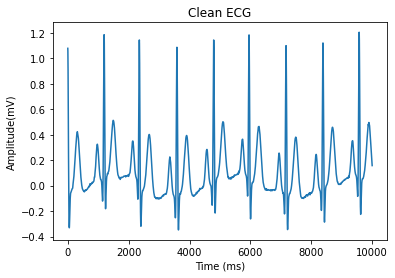

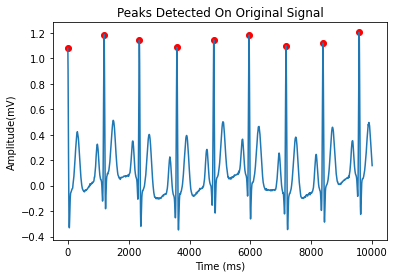

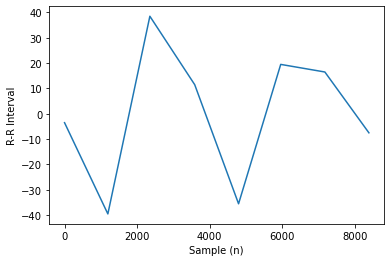

The SDNN is 25.387004549572207
The RMSSD is 44.606213532581826
The PNN50 is 25.0 %


In [15]:
#Testing the functions with synthetic data that has already successfully passed the peak detection
# We generate three different synthethic ECG signals. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50) # No noise, HR:50
ecg80 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80) # No noise, HR:80
ecg100 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=100) # No noise, HR:100

#Plotting the signals 
plt.plot(ecg50)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude(mV)")
plt.title("Clean ECG")
plt.show()

#Filtering the signals and plotting them in each step of the process
peaks = _filteringdet(ecg50,1000)

#Detecting the peaks and plotting them
plt.plot(ecg50)
plt.scatter(peaks['x_values'],peaks['y_values'], marker='o', color='r')
plt.ylabel("Amplitude(mV)")
plt.xlabel("Time (ms)")
plt.title("Peaks Detected On Original Signal")
plt.show()

#Calculate the time domain HRV parameters 
RR_data = RR_calculator(peaks)  #Calculating RR intervals
SDNN =  SDNN_calculator(RR_data) #Calculating the SDNN parameter
RMSSD = RMSSD_calculator(RR_data) #Calculating the RMSSD parameter
PNN50 = PNN50_calculator(RR_data) #Calculating the PNN50 parameters
